In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Subir un nivel desde el directorio actual del notebook
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from train_pinn import FireSpread_PINN

Using device: cuda


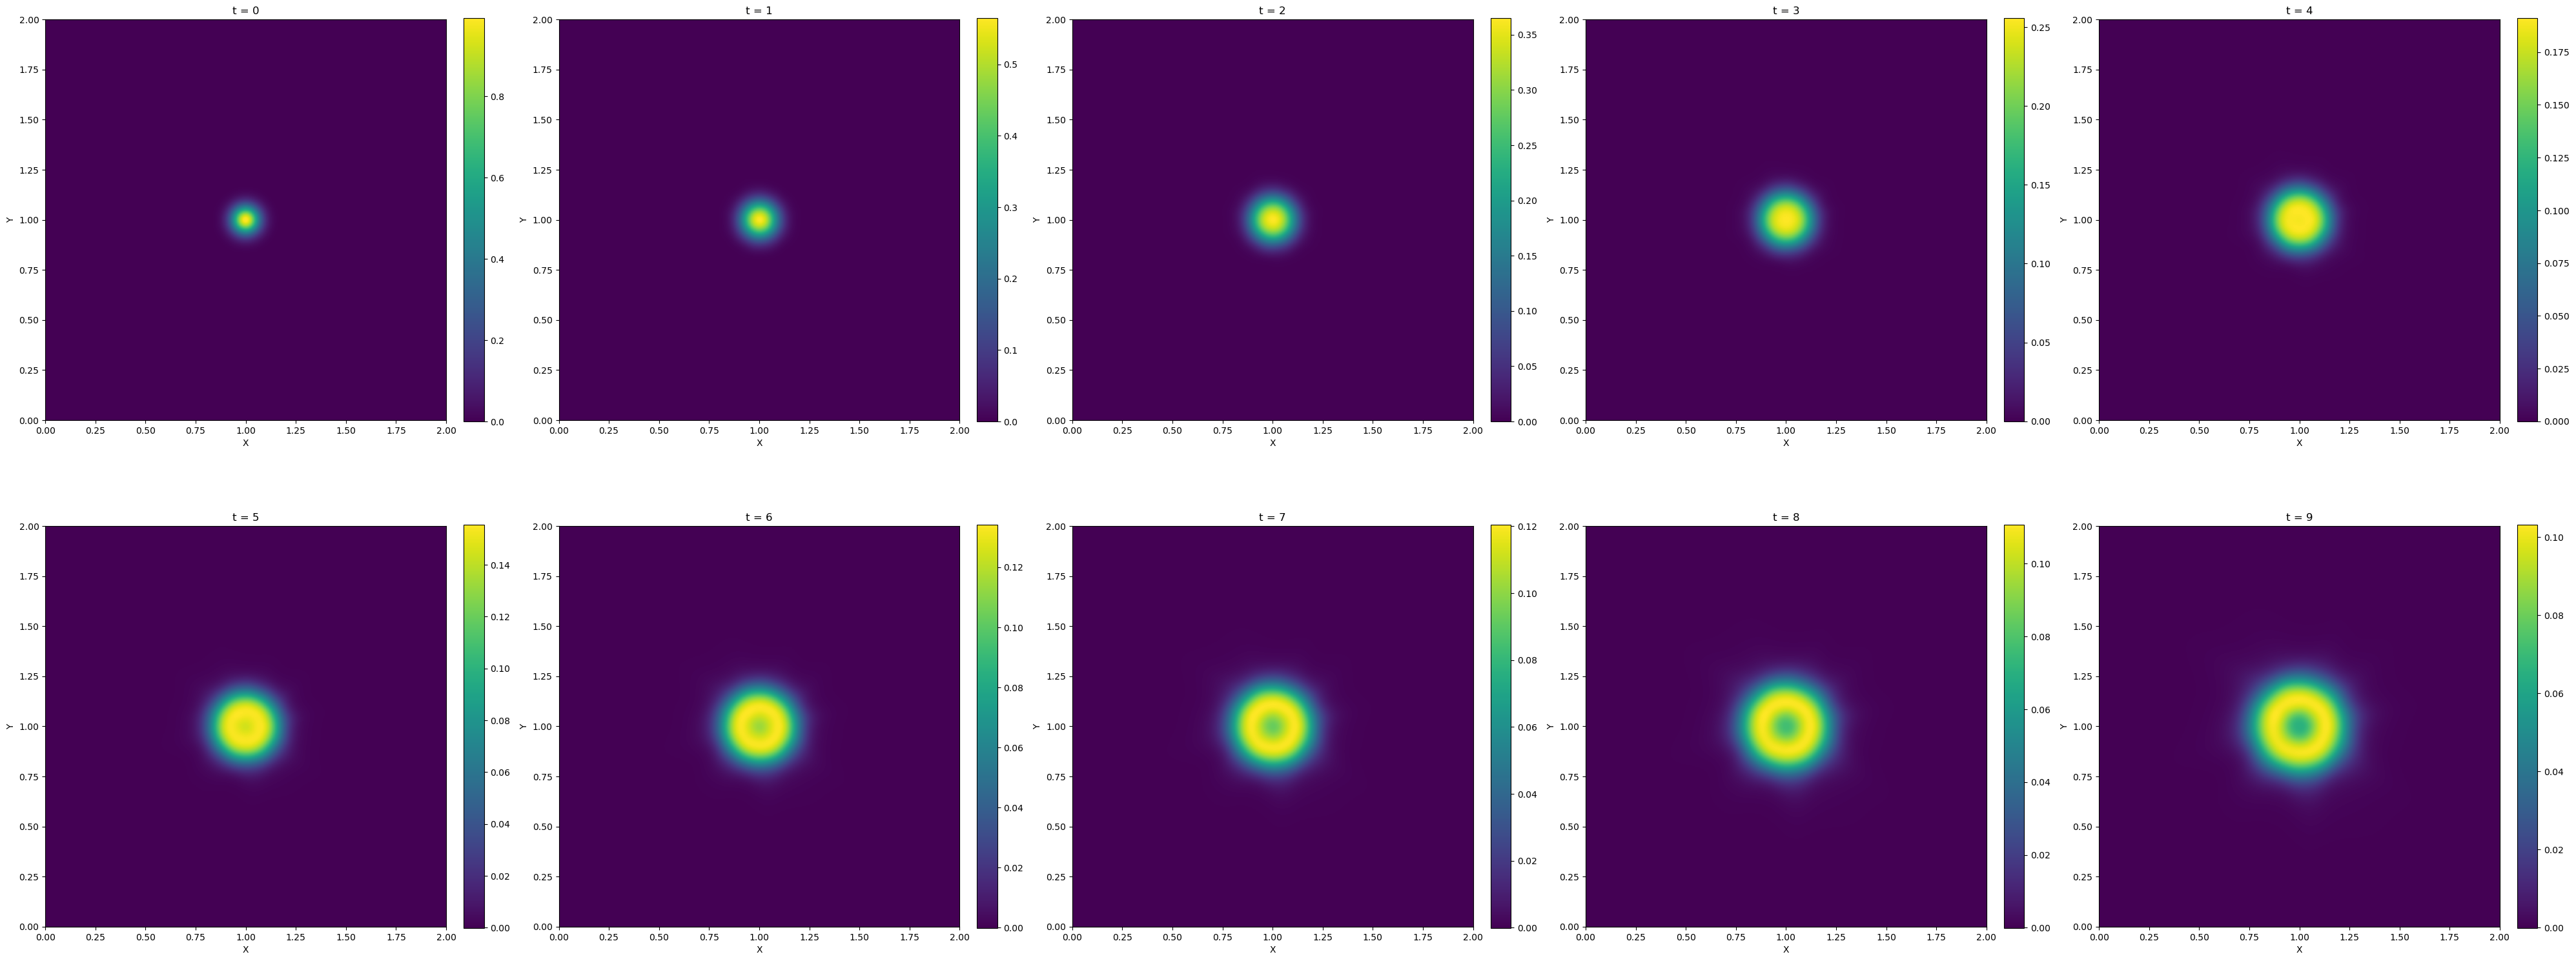

In [2]:
# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar modelo
model = FireSpread_PINN().to(device)
model.load_state_dict(torch.load("adaptive_pinns_DI0.0005_beta0.5_task1821999.pth", map_location=device, weights_only=True))
model.eval()

# Resolución espacial
Nx, Ny = 2000, 2000
x = torch.linspace(0, 2, Nx, device=device).view(-1, 1)
y = torch.linspace(0, 2, Ny, device=device).view(-1, 1)
X, Y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
x_flat, y_flat = X.flatten().view(-1, 1), Y.flatten().view(-1, 1)

# Crear grilla de subplots
fig, axes = plt.subplots(2, 5, figsize=(40, 16))  # 2 filas × 5 columnas
axes = axes.flatten()  # Para iterar fácilmente

for t_eval in range(10):
    t_fixed = torch.full_like(x_flat, t_eval, device=device)
    with torch.no_grad():
        SIR = model(x_flat, y_flat, t_fixed).view(Nx, Ny, 3).cpu().numpy()
        I = SIR[:, :, 1]

    ax = axes[t_eval]
    im = ax.imshow(I, interpolation='nearest', origin='lower',
                   extent=[0, 2, 0, 2])
    ax.set_title(f"t = {t_eval}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Ajustar layout
plt.tight_layout()
plt.show()

In [3]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))
from modelo_rdc import spread_infection_explicit_raw, spread_infection_adi
import cupy as cp

def ensure_batch_dim(*arrays):
    return [arr if arr.ndim == 3 else arr[cp.newaxis, ...] for arr in arrays]

In [11]:
ny, nx = 200, 200
num_steps = 2000

d = cp.float32(2 / nx)
dt = cp.float32(10 / 1000)

vegetacion = cp.full((ny, nx), 3.0, dtype=cp.float32)

beta_val = 1.0
gamma_val = 0.3

beta = cp.full_like(vegetacion, beta_val)
gamma = cp.full_like(vegetacion, gamma_val)

D_val = 5e-4
D = cp.asarray(D_val, dtype=cp.float32).reshape(1)
A = cp.asarray(0, dtype=cp.float32).reshape(1)
B = cp.asarray(0, dtype=cp.float32).reshape(1)

y = cp.linspace(0, 2, nx, dtype=cp.float32)
x = cp.linspace(0, 2, nx, dtype=cp.float32)

x_ign = 1
y_ign = 1
sigma_x = 0.05
sigma_y = 0.05

X_grilla, Y_grilla = cp.meshgrid(x, y, indexing='ij')

I = cp.exp(-0.5 * ((X_grilla - x_ign) / sigma_x)**2 - 0.5 * ((Y_grilla - y_ign) / sigma_y)**2)
S = 1 - I
R = cp.zeros_like(I)

wx = cp.zeros_like(S)
wy = cp.zeros_like(S)
h_dx = cp.zeros_like(S)
h_dy = cp.zeros_like(S)

S_new = cp.empty_like(S)
I_new = cp.empty_like(I)
R_new = cp.empty_like(R)

S, I, R, S_new, I_new, R_new, wx, wy, h_dx, h_dy, vegetacion = ensure_batch_dim(S, I, R, S_new, I_new, R_new, wx, wy, h_dx, h_dy, vegetacion)

for t in range(num_steps):
    spread_infection_adi(S, I, R, S_new, I_new, R_new, dt, d, beta, gamma, D,
                       wx, wy, h_dx, h_dy, A, B, vegetacion)

    # Swap de Buffers
    S, S_new = S_new, S
    I, I_new = I_new, I
    R, R_new = R_new, R

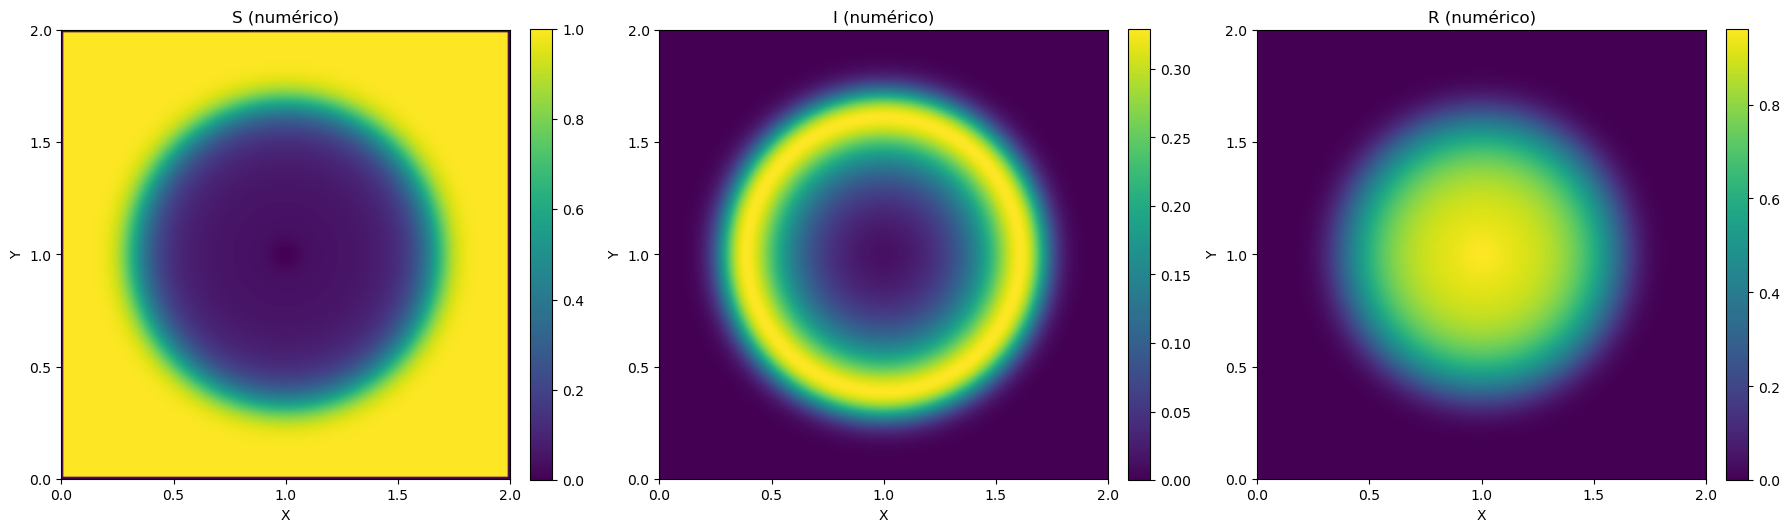

TypeError: expected str, bytes or os.PathLike object, not ndarray

In [12]:
import matplotlib.pyplot as plt

R_numpy = cp.squeeze(R.get())
S_numpy = cp.squeeze(S.get())
I_numpy = cp.squeeze(I.get())

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, data, title in zip(axes, [S_numpy, I_numpy, R_numpy], ["S (numérico)", "I (numérico)", "R (numérico)"]):
    # No fijar vmin/vmax: cada imagen tendrá su propia escala de color
    im = ax.imshow(data, origin='lower', extent=[0, 2, 0, 2],
                   aspect='equal', cmap='viridis')
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_xticks(np.linspace(0, 2, 5))
    ax.set_yticks(np.linspace(0, 2, 5))
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

np.save(S_numpy, f"S_numpy_D{D_val}_beta{beta_val}_gamma{gamma_val}_t{num_steps/10}.npy")
np.save(I_numpy, f"I_numpy_D{D_val}_beta{beta_val}_gamma{gamma_val}_t{num_steps/10}.npy")
np.save(R_numpy, f"R_numpy_D{D_val}_beta{beta_val}_gamma{gamma_val}_t{num_steps/10}.npy")


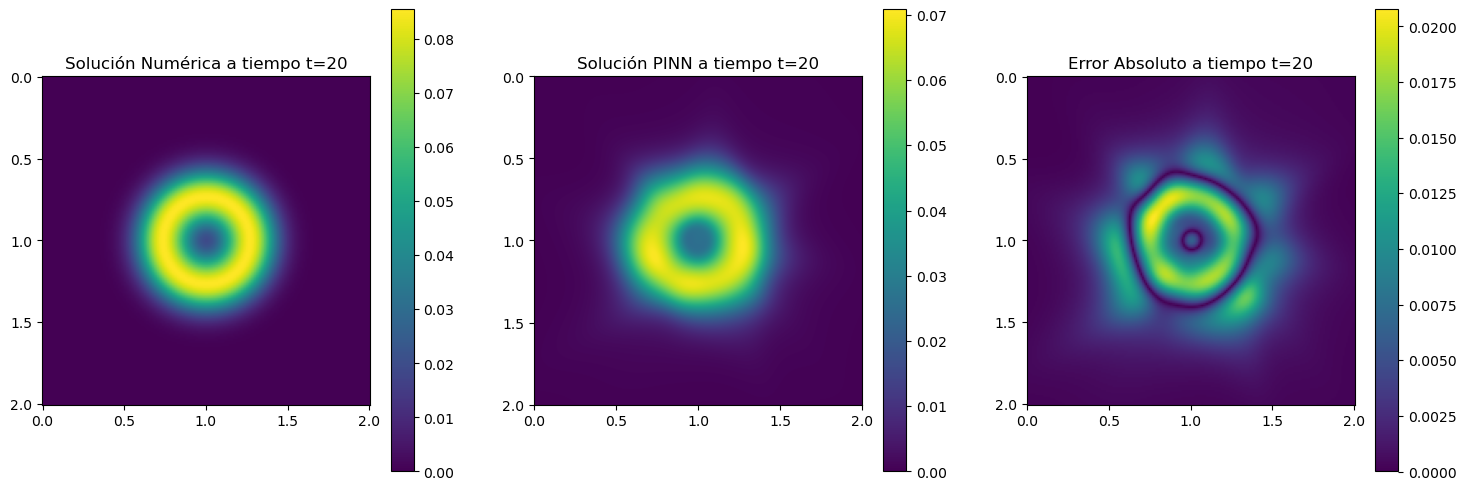

Error absoluto medio: 0.0032199547
Error absoluto máximo: 0.020758405
Error absoluto mínimo: 2.8669904e-14


In [ ]:
R_numpy = cp.squeeze(R.get())
S_numpy = cp.squeeze(S.get())
I_numpy = cp.squeeze(I.get())

t_eval = 20

t_fixed = torch.full_like(x_flat, t_eval, device=device)
with torch.no_grad():
    SIR = model(x_flat, y_flat, t_fixed).view(Nx, Ny, 3).cpu().numpy()
    I_pinn = SIR[:, :, 1]

figs, axes = plt.subplots(1, 3, figsize=(18, 6))

ax1, ax2, ax3 = axes
im1 = ax1.imshow(I_numpy, aspect='equal')
cbar1 = figs.colorbar(im1, ax=ax1)
ax1.set_xticks(np.linspace(0, I_numpy.shape[1]-1, 5))
ax1.set_xticklabels(np.linspace(0, 2, 5))
ax1.set_yticks(np.linspace(0, I_numpy.shape[0]-1, 5))
ax1.set_yticklabels(np.linspace(0, 2, 5))
ax1.set_title(f"Solución Numérica a tiempo t={t_eval}")

im2 = ax2.imshow(I_pinn, aspect='equal')
cbar2 = figs.colorbar(im2, ax=ax2)
ax2.set_xticks(np.linspace(0, I_pinn.shape[1]-1, 5))
ax2.set_xticklabels(np.linspace(0, 2, 5))
ax2.set_yticks(np.linspace(0, I_pinn.shape[0]-1, 5))
ax2.set_yticklabels(np.linspace(0, 2, 5))
ax2.set_title(f"Solución PINN a tiempo t={t_eval}")

error_abs = np.abs(I_pinn[::10, ::10] - I_numpy)
im3 = ax3.imshow(error_abs, aspect='equal')
cbar3 = figs.colorbar(im3, ax=ax3)
ax3.set_xticks(np.linspace(0, error_abs.shape[1]-1, 5))
ax3.set_xticklabels(np.linspace(0, 2, 5))
ax3.set_yticks(np.linspace(0, error_abs.shape[0]-1, 5))
ax3.set_yticklabels(np.linspace(0, 2, 5))
ax3.set_title(f"Error Absoluto a tiempo t={t_eval}")

plt.show()

# Mostrar el error medio y máximo
print("Error absoluto medio:", np.mean(error_abs))
print("Error absoluto máximo:", np.max(error_abs))
print("Error absoluto mínimo:", np.min(error_abs))


Error absoluto medio: 0.0005957311
Error absoluto máximo: 0.078758895


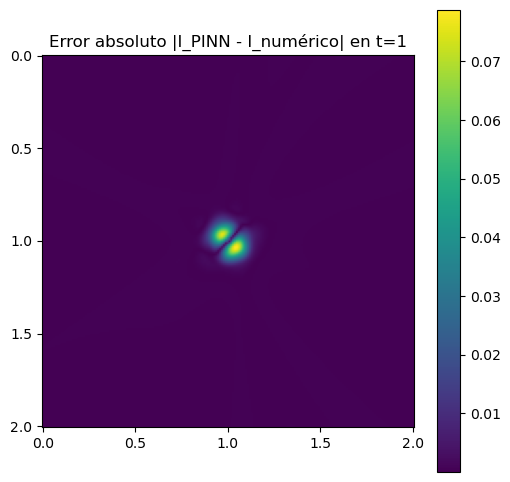

In [63]:
# Calcular el error absoluto entre la PINN y la solución numérica en t=0
x_flat, y_flat = X.flatten().view(-1, 1), Y.flatten().view(-1, 1)

t_fixed = torch.full_like(x_flat, 0, device=device)
with torch.no_grad():
    SIR = model(x_flat, y_flat, t_fixed).view(Nx, Ny, 3).cpu().numpy()
    I_pinn = SIR[:, :, 1]

# Error absoluto
error_abs = np.abs(I_pinn[::10, ::10] - I_numpy)

# Mostrar el error medio y máximo
print("Error absoluto medio:", np.mean(error_abs))
print("Error absoluto máximo:", np.max(error_abs))

# Visualizar el mapa de error
plt.figure(figsize=(6, 6))
plt.imshow(error_abs, cmap='viridis', aspect='equal')
plt.title("Error absoluto |I_PINN - I_numérico| en t=1")
plt.xticks(np.linspace(0, error_abs.shape[1]-1, 5), np.linspace(0, 2, 5))
plt.yticks(np.linspace(0, error_abs.shape[0]-1, 5), np.linspace(0, 2, 5))
plt.colorbar()
plt.show()